In [7]:
import matplotlib.pyplot as plt
import os
from common.lang import Lang,LangType
import pandas as pd
import numpy as np
from rppg_toolbox.src.common.import_tqdm import  tqdm
import matplotlib.font_manager as fm
fm.fontManager.addfont('/public/home/gnaloaixey/font/TIMES.TTF')
outdir = 'out/compression/img'
lang_type = LangType.en_us
# motion = 'wark'
motion = 'static'
dataset_name = "ZJXU-MOTION"
# dataset_name = "UBFC_Phys"

lang = Lang(lang_type=lang_type)
t = lang.t
font_map = {
    LangType.zh_cn:'KaiTi', # SimHei
    LangType.en_us:'Times New Roman'
}

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['font.sans-serif'] = font_map[lang_type]
plt.rcParams['axes.unicode_minus'] = False
os.makedirs(outdir, exist_ok=True)



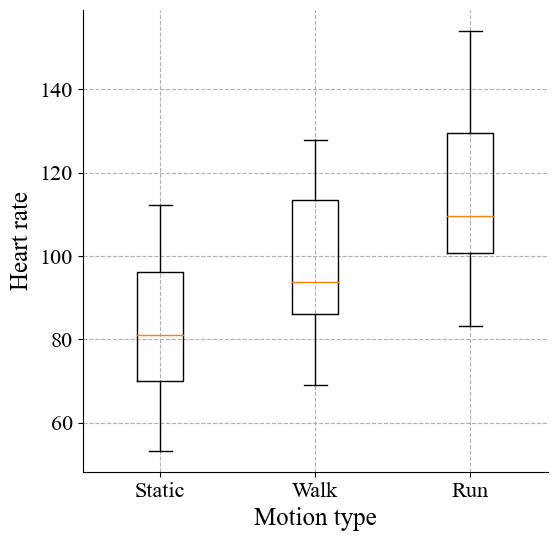

<Figure size 640x480 with 0 Axes>

In [9]:
from pathlib import Path
from os import path
import pandas as pd
dataset_root = os.path.expanduser(r'/public/share/weiyuanwang/dataset/ZJXU-MOTION')
dataset_root_path = Path(dataset_root)
lang.add_map(LangType.zh_cn,{
        'static':'静止',
        'walk':'走路',
        'run':'跑步',
        'motion_type':'运动类型',
        'heart_rate':'心率'
    }).add_map(LangType.en_us,{
        'static':'Static',
        'walk':'Walk',
        'run':'Run',
        'motion_type':'Motion type',
        'heart_rate':'Heart rate'
    })
heart_rate_data = {
    t('static'): [],
    t('walk'): [],
    t('run'): [],
}


for item in dataset_root_path.iterdir():
    if not item.is_dir() or not item.name.startswith('s'):
        continue
    for item in item.iterdir():
        hr_list = []
        if item.name.startswith('S_'):
            hr_list = heart_rate_data.get(t('static'))
        if item.name.startswith('W_'):
            hr_list = heart_rate_data.get(t('walk'))
        if item.name.startswith('R_'):
            hr_list = heart_rate_data.get(t('run'))
            pass
        for item in item.iterdir():
            if item.is_dir() and item.name.isdigit():
                wave_csv_path = None
                for sub_path in item.iterdir():
                    if sub_path.name.startswith("ppg") and sub_path.name.endswith(".csv"):
                        wave_csv_path = sub_path
                if wave_csv_path == None:
                    print('no wave file')
                    break
                df = pd.read_csv(wave_csv_path)
                hr_list.append(df.iloc[:,3].mean())
# 心率图例


labels = list(heart_rate_data.keys())
data = list(heart_rate_data.values())

plt.figure(figsize=(6,6))




plt.boxplot(data, labels=labels)

plt.xlabel(t('motion_type'),fontsize=18)
plt.ylabel(t('heart_rate'),fontsize=18)

plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.grid(True, linestyle='--')
plt.savefig(f"{outdir}/heart_rate.pdf",transparent=True,bbox_inches='tight')
plt.savefig(f"{outdir}/heart_rate.svg",transparent=True,bbox_inches='tight')
plt.show()
plt.clf()


In [2]:
# skin color
from rppg_toolbox.src.dataset_reader.ZJXU_MOTION import ZJXU_MOTION_Reader
from rppg_toolbox.src.face_detector.mtcnn.detector import detect_faces
import cv2

dataset_root = os.path.expanduser(r'/public/share/weiyuanwang/dataset/ZJXU-MOTION')
test_dataset_reader = ZJXU_MOTION_Reader(
    dataset_root,
    samples=[f's0{i}' for i in range(1,10)]+[f's{i}' for i in range(10,21)],
    scenes=['S_L1'])
list_of_info_data,list_of_video_path = test_dataset_reader.read()
list_of_video = [i.usb_camera_left for i in list_of_video_path]

skin_color_list = []
progress_bar = tqdm(list_of_video, desc=f"Skin Color")
for i,video_path in enumerate(progress_bar):
    cap = cv2.VideoCapture(video_path)
    index = 0
    face = None
    colors = []
    for i in range(10):
        ret1, frame_1 = cap.read()
        if not ret1:
            break
        bounding_boxes, landmarks = detect_faces(cv2.cvtColor(frame_1, cv2.COLOR_BGR2RGB))
        if len(bounding_boxes) <= 0:
            continue
        largest_face = max(bounding_boxes, key=lambda box: (box[2] - box[0]) * (box[3] - box[1]))
        x1, y1, x2, y2,score = largest_face
        x1, y1, x2, y2 = [int(v) for v in [x1, y1, x2, y2]]
        frame_face = frame_1[y1:y2, x1:x2]
        colors.append(cv2.cvtColor(frame_face,cv2.COLOR_BGR2GRAY).mean())
    skin_color_list.append([np.array(colors).mean()])
    cap.release()
# skin_color_list = np.array(skin_color_list).T
# file_path = f'out/compression/skin_color.csv'
# df = pd.DataFrame(skin_color_list)
# df.to_csv(file_path,header=range(len(video_path)),index=None)

Root Path:/public/share/weiyuanwang/dataset/ZJXU-MOTION
Start Reading Dataset Directory...


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Skin Color:   0%|          | 0/20 [00:00<?, ?it/s]

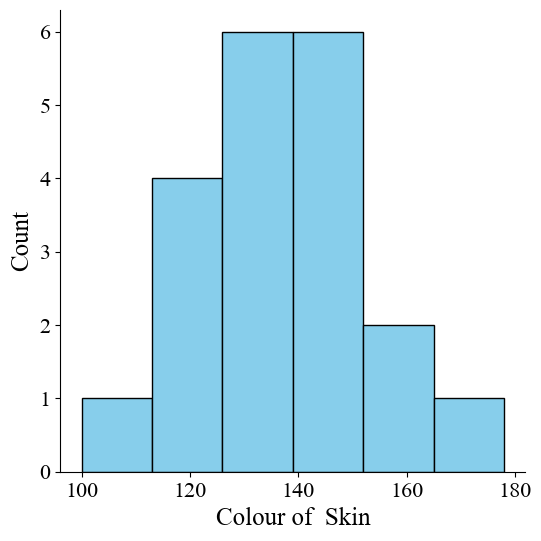

<Figure size 640x480 with 0 Axes>

In [18]:
# 肤色图例
import matplotlib.pyplot as plt
import numpy as np
lang.add_map(LangType.zh_cn,{
        'count':'数量',
        'colour_of_skin':'肤色区间',
    }).add_map(LangType.en_us,{
        'count':'Count',
        'colour_of_skin':'Colour of  Skin',
    })

skin_color_data = skin_color_list.flatten()
skin_color_data = np.clip(skin_color_data, 100, 181)

bins = np.arange(100, 181, 13)  # 分成6个区间，每个区间宽度为13
plt.figure(figsize=(6,6))

plt.xlabel(t('colour_of_skin'),fontsize=18)
plt.ylabel(t('count'),fontsize=18)

plt.hist(skin_color_data, bins=bins, color='skyblue', edgecolor='black', alpha=1)


plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
# plt.grid(True, linestyle='--',axis='y')
plt.savefig(f"{outdir}/colour_of_skin.pdf",transparent=True,bbox_inches='tight')
plt.savefig(f"{outdir}/colour_of_skin.svg",transparent=True,bbox_inches='tight')
# 显示图表
plt.show()
plt.clf()

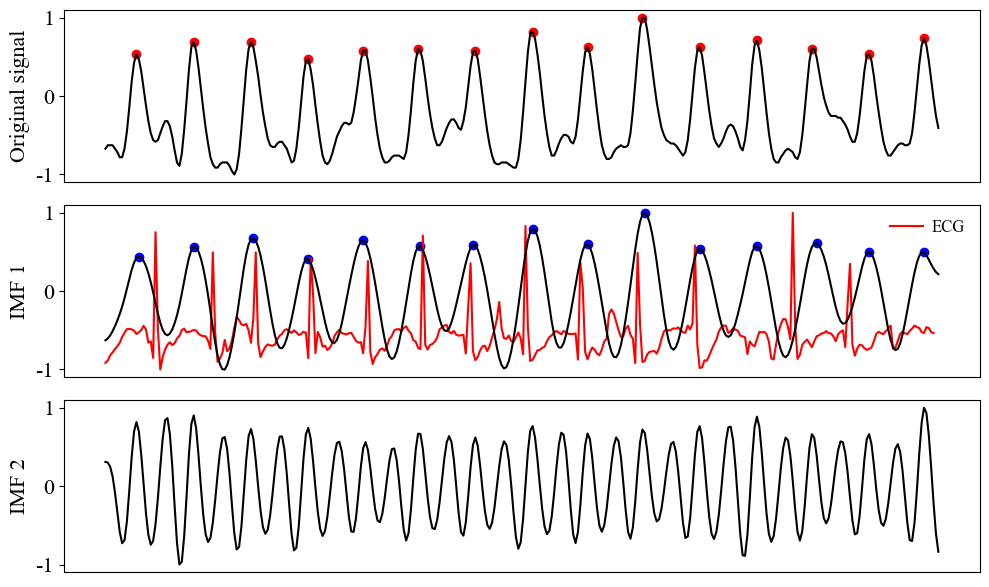

<Figure size 640x480 with 0 Axes>

In [17]:
from vmdpy import VMD
from scipy.signal import find_peaks

start = 50
num = 350
ppg_signal = pd.read_csv('out/ppg_2.csv').iloc[:,1].to_numpy()
ecg_signal = pd.read_csv('out/ecg_2.csv').iloc[:,2].to_numpy()

# 插值
frame_time_stamps = np.linspace(0,1,len(ecg_signal))
frame_time_stamps_xp = np.linspace(0,1,len(ppg_signal))
ecg_signal = np.interp(
    frame_time_stamps_xp,
    frame_time_stamps,
    ecg_signal
    )

ppg_signal = ppg_signal[start:start+num]
ecg_signal = ecg_signal[start:start+num]

indices_to_remove = list(range(50, 56)) + list(range(140,144)) + list(range(280,286))
ecg_signal = ecg_signal[~np.isin(np.arange(len(ecg_signal)), indices_to_remove)]
indices_to_insert = ecg_signal[320:335]
ecg_signal = np.insert(ecg_signal,330,indices_to_insert)

for i,v in enumerate(ppg_signal):
    if v > 160:
        a = ppg_signal[i+1] if i == 0 else ppg_signal[i-1]
        b = ppg_signal[i-1] if i == len(ppg_signal) - 1 else ppg_signal[i+1]
        ppg_signal[i] = (a+b)/2


ecg_signal = (ecg_signal-ecg_signal.mean())/ecg_signal.std() - 1
original_signal = (ppg_signal-ppg_signal.mean())/ppg_signal.std()

x = np.arange(len(original_signal))
# 使用 VMD 进行信号分解
# alpha 惩罚系数；带宽限制经验取值为抽样点长度1.5-2.0倍.
# 惩罚系数越小，各IMF分量的带宽越大，过大的带宽会使得某些分量包含其他分量言号;
# a值越大，各IMF分量的带宽越小，过小的带宽是使得被分解的信号中某些信号丢失该系数常见取值范围为1000~3000
alpha=200
tau=0 # tau 噪声容限，即允许重构后的信号与原始信号有差别。
K=2 # K 分解模态（IMF）个数
DC=0 # DC 若为0则让第一个IMF为直流分量/趋势向量
init=1 # init 指每个IMF的中心频率进行初始化。当初始化为1时，进行均匀初始化。
tol=1e-7 # 控制误差大小常量，决定精度与迭代次数
IMFs, IMFs_hat, IMFs_omega = VMD(original_signal, alpha, tau, K, DC, init, tol) # 输出U是各个IMF分量，u_hat是各IMF的频谱，omega为各IMF的中心频率

# 绘制子图
plt.figure(figsize=(10, 6))

# 绘制原始信号
plt.subplot(len(IMFs) + 1, 1, 1)
plt.yticks([-1,0,1])
plt.xticks([])
ax = plt.gca()
# ax.spines['left'].set_color('none')
# ax.spines['right'].set_color('none')
original_signal = (original_signal -original_signal.min())/(original_signal.max()-original_signal.min()) * 2 - 1
plt.plot(original_signal, color='black')
peaks, _ = find_peaks(original_signal, height=0)
plt.scatter(x[peaks], original_signal[peaks], color='red')
# plt.title('Original signal',fontsize=16)
plt.ylabel('Original signal',fontsize=16)
# IMFs[0] += IMFs[1]
# 绘制分解后的每个模态函数
for i, imf in enumerate(IMFs):
    imf = np.array(imf)
    imf = (imf-imf.mean())/imf.std()
    imf = (imf -imf.min())/(imf.max()-imf.min()) * 2 - 1
    plt.subplot(len(IMFs) + 1, 1, i + 2)
    plt.yticks([-1,0,1])
    plt.xticks([])
    ax = plt.gca()
    # ax.spines['left'].set_color('none')
    # ax.spines['right'].set_color('none')
    if i == 0:
        peaks, _ = find_peaks(imf, height=0)
        plt.scatter(x[peaks], imf[peaks], color='blue')
        ecg_signal = (ecg_signal -ecg_signal.min())/(ecg_signal.max()-ecg_signal.min()) * 2 - 1
        plt.plot(ecg_signal, color='red',label='ECG')
        legend = ax.legend(handlelength=2, handletextpad=0.5,framealpha=0, edgecolor='#e6e6e6', loc='upper right',fontsize=12)
        frame = legend.get_frame()
        frame.set_facecolor('white')
    plt.plot(imf, color='black')
    # if i == 0:
    #     plt.plot(ecg_signal, color='red')
    # plt.title(f'IMF {i+1}',fontsize=16)
    plt.ylabel(f'IMF {i+1}',fontsize=16)
plt.tight_layout()  # 调整子图布局，防止重叠
plt.savefig(f"{outdir}/vmd_image.svg",transparent=True,bbox_inches='tight')
plt.savefig(f"{outdir}/vmd_image.png",transparent=True,bbox_inches='tight')
plt.savefig(f"{outdir}/vmd_image.pdf",transparent=True,bbox_inches='tight')
plt.show()
plt.clf()

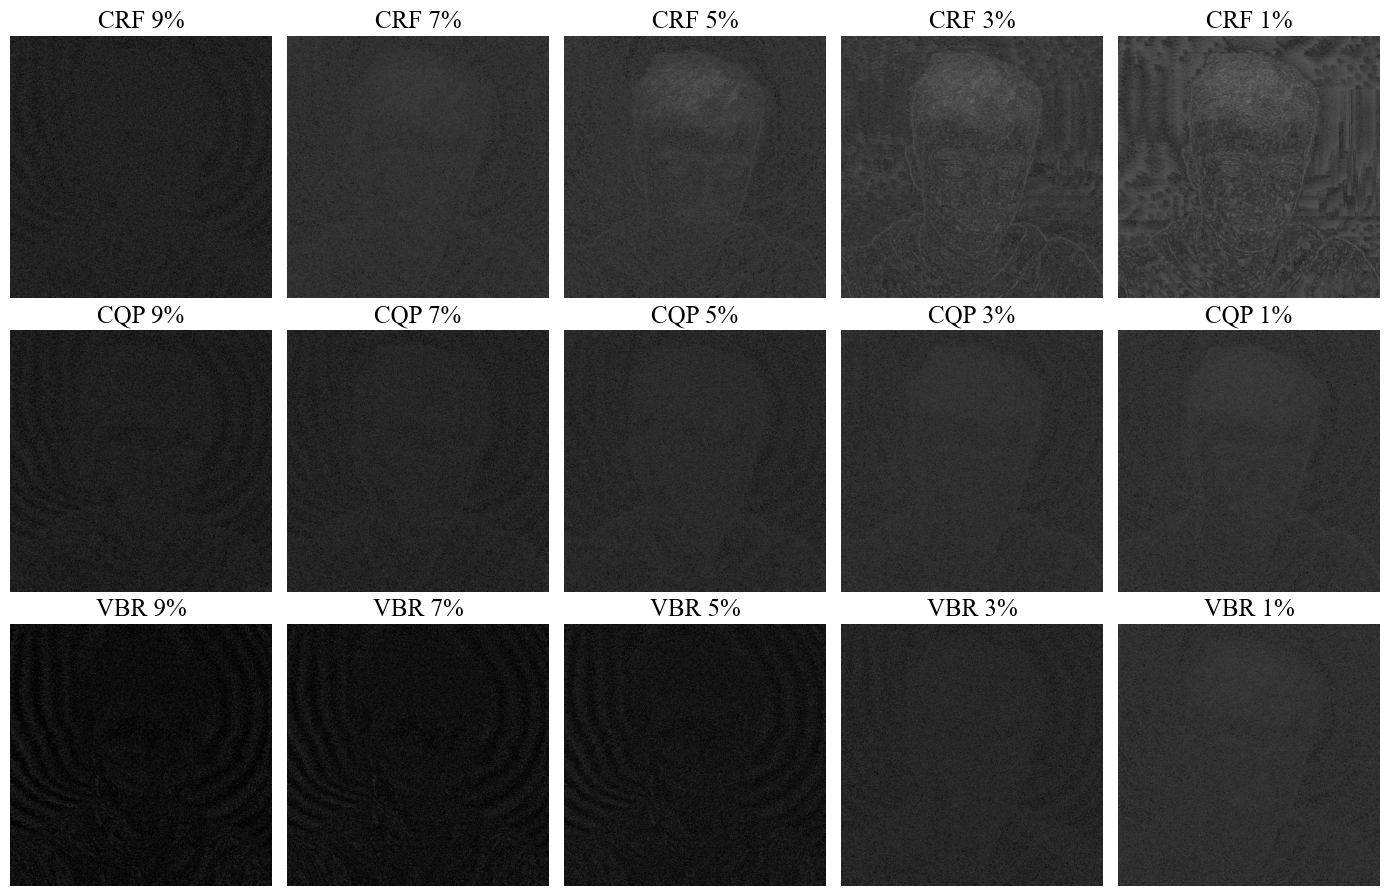

<Figure size 640x480 with 0 Axes>

In [3]:
# diff
frame = 19
# frame = 213
# codecs = ['libx264']
codecs = ['libx264']
# codecs = ['vp9']
for codec in codecs:
    file_names = [
        ('crf',1),('crf',10),('crf',20),('crf',30),('crf',35),
        ('qp',5),('qp',7),('qp',9),('qp',12),('qp',15),
        ('b',28),('b',30),('b',31),('b',33),('b',34),
    ]
    percentage = [9,7,5,3,1]
    # 创建画布和子图
    fig, axes = plt.subplots(3, 5, figsize=(14, 9))

    # 遍历文件名列表并绘制图像
    for i, file_name in enumerate(file_names):
        row = i // 5
        col = i % 5
        img = plt.imread(f'out/{dataset_name}/img/diff/{codec}_{motion}/{file_name[0]}__{file_name[1]}_{frame}.png')  # 读取图像
        axes[row, col].imshow(img)
        axes[row, col].axis('off')  # 去除坐标轴
        axes[row, col].set_title(f'{"CRF" if file_name[0] == "crf" else "CQP" if file_name[0]=="qp" else "VBR"} {percentage[col]}%',fontsize=18)  # 添加子标题


    # 调整水平间距
    plt.tight_layout(h_pad=1.5)
    plt.savefig(f"{outdir}/{dataset_name}_{motion}_diff_{codec}.pdf",transparent=True,bbox_inches='tight')
    plt.savefig(f"{outdir}/{dataset_name}_{motion}_diff_{codec}.svg",transparent=True,bbox_inches='tight')
    plt.savefig(f"{outdir}/{dataset_name}_{motion}_diff_{codec}.png",transparent=True,bbox_inches='tight')
    # 显示图像

    plt.show()
plt.clf()

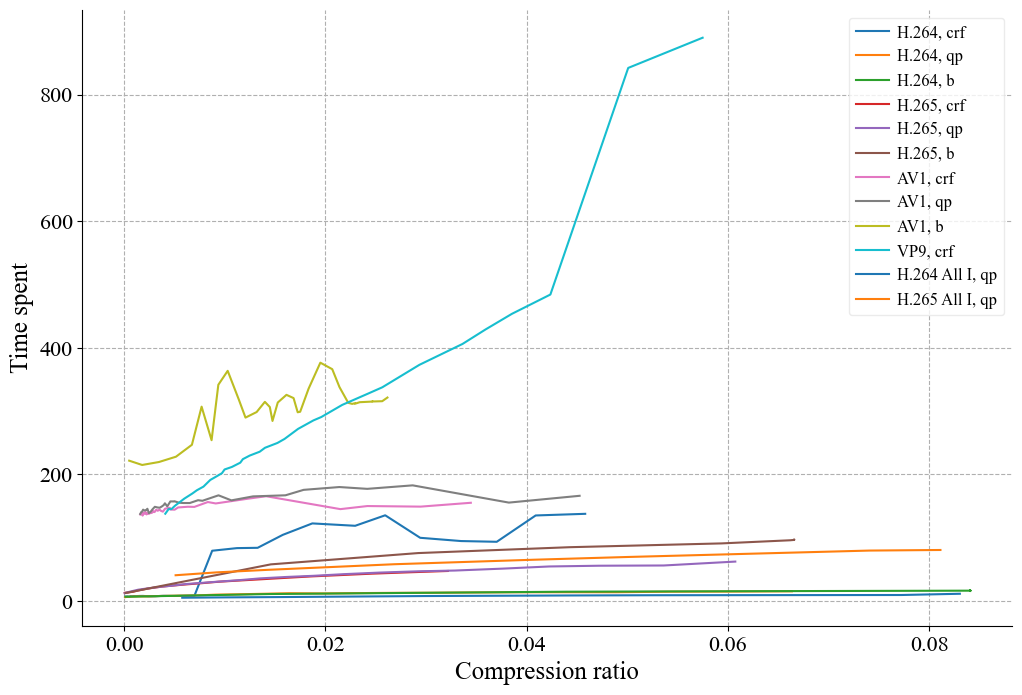

<Figure size 640x480 with 0 Axes>

In [13]:
# compression time
lang.add_map(LangType.zh_cn,{
        'bitrate':'压缩比',
        'ctime':'花费时间',
    }).add_map(LangType.en_us,{
        'bitrate':'Compression ratio',
        'ctime':'Time spent',
    })

codecs = ['libx264','libx265','av1','vp9','libx264_all_i','libx265_all_i']
titles = ['H.264','H.265','AV1','VP9','H.264 All I','H.265 All I']
compression_strengths = [range(1,36),range(1,36),range(1,36),range(1,36),[1,4,8,10,14,20,24,30],[1,4,8,10,14,20,24,30]]
modes = [['crf','qp','b'],['crf','qp','b'],['crf','qp','b'],['crf'],['qp'],['qp']]
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
for i,codec in enumerate(codecs):
    for j,mode in enumerate(modes[i]):
        x = []
        y = []
        for compression_strength in compression_strengths[i]:
            df_time = pd.read_excel(f'out/compression/{dataset_name}/compression_time_{motion}.xlsx', sheet_name=f'{codec}_{mode}_{compression_strength}')
            df_bitrate = pd.read_excel(f'out/compression/{dataset_name}/compression_ratios_{motion}.xlsx', sheet_name=f'{codec}_{mode}_{compression_strength}')
            x.append(df_bitrate.iloc[:,1].mean())
            y.append(df_time.iloc[:,1].mean())
        plt.plot(x,y,label=f'{titles[i]}, {mode}')
plt.xlabel(t('bitrate'),fontsize=18)
plt.ylabel(t('ctime'),fontsize=18)
plt.grid(True, linestyle='--')
plt.legend(handlelength=2, handletextpad=0.5,framealpha=0.8, edgecolor='#e6e6e6', loc='upper right',fontsize=12)
plt.savefig(f"{outdir}/{dataset_name}_ctime_bitrate_{motion}.pdf",transparent=True,bbox_inches='tight')
plt.savefig(f"{outdir}/{dataset_name}_ctime_bitrate_{motion}.svg",transparent=True,bbox_inches='tight')
# 显示图表
plt.show()
plt.clf()

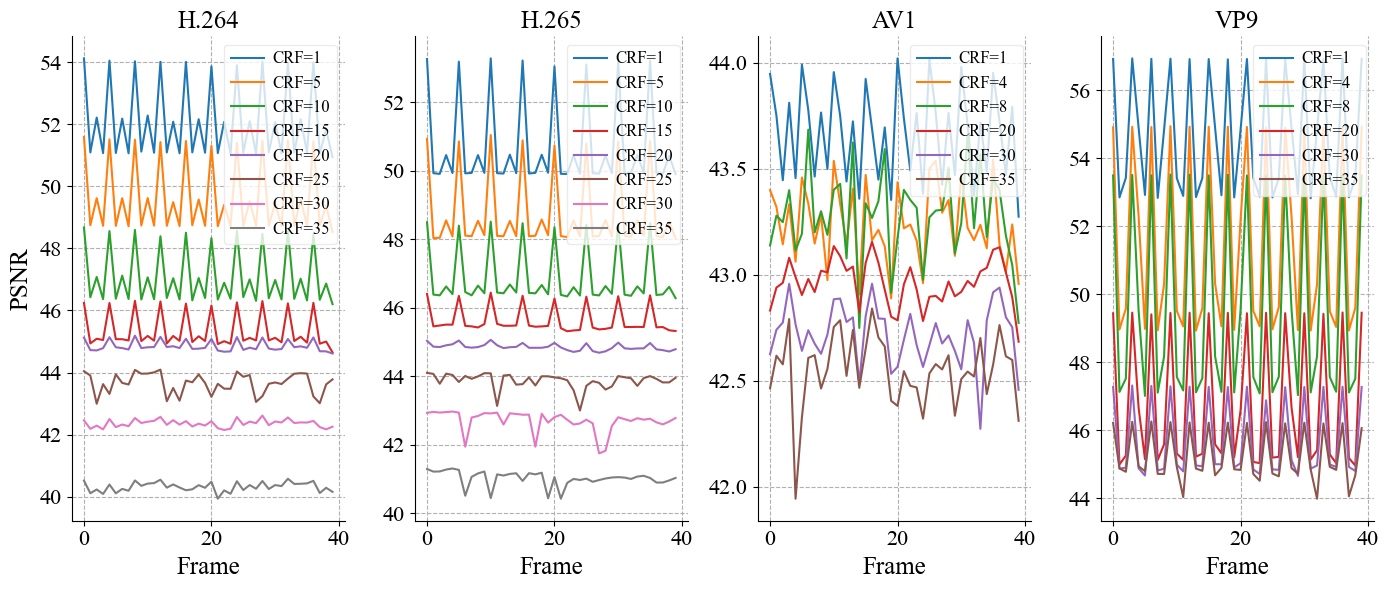

<Figure size 640x480 with 0 Axes>

In [4]:
# psnr value
lang.add_map(LangType.zh_cn,{
        'frame':'帧',
        'psnr':'PSNR',
    }).add_map(LangType.en_us,{
        'frame':'Frame',
        'psnr':'PSNR',
    })

fig, axes = plt.subplots(1, 4, figsize=(14, 6))
codecs = ['libx264','libx265','av1','vp9']
titles = ['H.264','H.265','AV1','VP9']
compression_strengths = [[1,5,10,15,20,25,30,35],[1,5,10,15,20,25,30,35],[1,4,8,20,30,35],[1,4,8,20,30,35],]

for i,codec in enumerate(codecs):
    ax = axes[i]
    for compression_strength in compression_strengths[i]:
        df_psnr = pd.read_excel(f'out/{dataset_name}/psnr_{motion}.xlsx', sheet_name=f'{codec}_crf_{compression_strength}')
        data = df_psnr.iloc[180:220,0].to_numpy()
        ax.plot(data,label=f'CRF={compression_strength}')
    ax.set_title(titles[i],fontsize=18)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xlabel(t('frame'),fontsize=18)
    if i == 0:
        ax.set_ylabel(t('psnr'),fontsize=18)
    else:
        ax.set_ylabel(None)
    ax.grid(True, linestyle='--')
    legend = ax.legend(handlelength=2, handletextpad=0.5,framealpha=0.8, edgecolor='#e6e6e6', loc='upper right',fontsize=12)
    frame = legend.get_frame()
    # frame.set_facecolor('white')

plt.tight_layout(h_pad=2.5)

plt.savefig(f"{outdir}/{dataset_name}_psnr_{motion}.pdf",transparent=True,bbox_inches='tight')
plt.savefig(f"{outdir}/{dataset_name}_psnr_{motion}.svg",transparent=True,bbox_inches='tight')
# 显示图表
plt.show()
plt.clf()

In [2]:
# psnr crf qp b
from scipy.interpolate import UnivariateSpline

def get_x_y(codec,mode,mean_or_std):
    compression_strengths = range(1,36,2)
    if codec == 'mjpeg':
        compression_strengths = range(2,32)
    if codec == 'prores_ks':
        compression_strengths = range(0,5)
    if codec == 'libx264_all_i' or codec == 'libx265_all_i':
        compression_strengths = [1,4,8,10,14,20,24,30]
    x = list()
    y = list()
    for compression_strength in compression_strengths:
        df_compression_ratios = pd.read_excel(f'out/{dataset_name}/compression_ratios_{motion}.xlsx', sheet_name=f'{codec}_{mode}_{compression_strength}')
        x.append(df_compression_ratios.iloc[0,:].to_numpy().mean())
        df_psnr = pd.read_excel(f'out/{dataset_name}/psnr_{motion}.xlsx', sheet_name=f'{codec}_{mode}_{compression_strength}')
        psnr = df_psnr.to_numpy().reshape(-1)
        psnr_not_inf = np.array(list(filter(lambda i:i != np.inf,psnr)))
        if mean_or_std == "mean":
            y.append(psnr_not_inf.mean())
        else:
            y.append(psnr_not_inf.std())
    zipped = sorted(zip(x, y))
    # zipped = filter(lambda i:i[0]>=0.02 and i[0] < 0.17,zipped)
    zipped = filter(lambda i:i[0]>=0.02,zipped)
    x,y = zip(*zipped)
    x = np.array(x)
    y = np.array(y)
    # if codec == 'prores_ks':
    #     xx = np.linspace(0.02,0.15,10)
    #     y = UnivariateSpline(x, y,k=3,s=1)(xx)
    #     x = xx
    return x,y

In [3]:
x_h264_crf_mean,y_h264_crf_mean = get_x_y('libx264','crf','mean')
x_h264_qp_mean,y_h264_qp_mean = get_x_y('libx264','qp','mean')
x_h264_b_mean,y_h264_b_mean = get_x_y('libx264','b','mean')

x_h265_crf_mean,y_h265_crf_mean = get_x_y('libx265','crf','mean')
x_h265_qp_mean,y_h265_qp_mean = get_x_y('libx265','qp','mean')
x_h265_b_mean,y_h265_b_mean = get_x_y('libx265','b','mean')

x_av1_crf_mean,y_av1_crf_mean = get_x_y('av1','crf','mean')
x_av1_qp_mean,y_av1_qp_mean = get_x_y('av1','qp','mean')
x_av1_b_mean,y_av1_b_mean = get_x_y('av1','b','mean')

x_vp9_crf_mean,y_vp9_crf_mean = get_x_y('vp9','crf','mean')
x_vp9_b_mean,y_vp9_b_mean = get_x_y('vp9','b','mean')



# std
x_h264_crf_std,y_h264_crf_std = get_x_y('libx264','crf','std')
x_h264_qp_std,y_h264_qp_std = get_x_y('libx264','qp','std')
x_h264_b_std,y_h264_b_std = get_x_y('libx264','b','std')

x_h265_crf_std,y_h265_crf_std = get_x_y('libx265','crf','std')
x_h265_qp_std,y_h265_qp_std = get_x_y('libx265','qp','std')
x_h265_b_std,y_h265_b_std = get_x_y('libx265','b','std')

x_av1_crf_std,y_av1_crf_std = get_x_y('av1','crf','std')
x_av1_qp_std,y_av1_qp_std = get_x_y('av1','qp','std')
x_av1_b_std,y_av1_b_std = get_x_y('av1','b','std')

x_vp9_crf_std,y_vp9_crf_std = get_x_y('vp9','crf','std')
x_vp9_b_std,y_vp9_b_std = get_x_y('vp9','b','std')

In [4]:
x_mjpeg_mean,y_mjpeg_mean = get_x_y('mjpeg','q','mean')
x_mjpeg_std,y_mjpeg_std = get_x_y('mjpeg','q','std')
x_prores_ks_mean,y_prores_ks_mean = get_x_y('prores_ks','q','mean')
x_prores_ks_std,y_prores_ks_std = get_x_y('prores_ks','q','std')
x_h264_alli_mean,y_h264_alli_mean = get_x_y('libx264_all_i','qp','mean')
x_h264_alli_std,y_h264_alli_std = get_x_y('libx264_all_i','qp','std')
x_h265_alli_mean,y_h265_alli_mean = get_x_y('libx265_all_i','qp','mean')
x_h265_alli_std,y_h265_alli_std = get_x_y('libx265_all_i','qp','std')

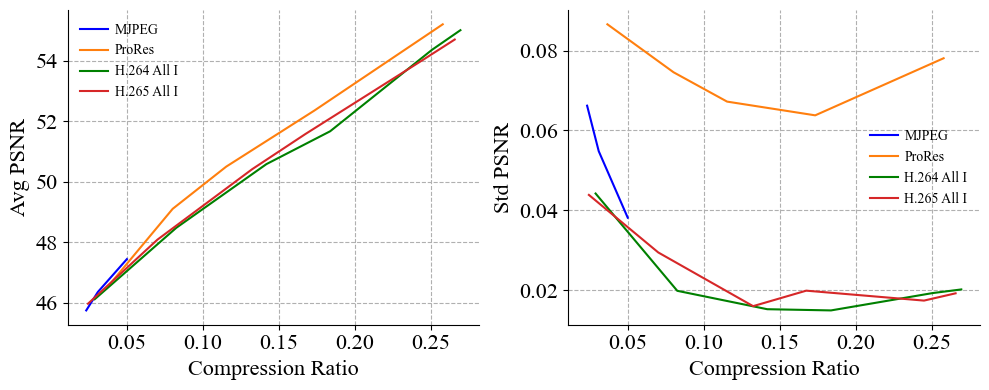

<Figure size 640x480 with 0 Axes>

In [5]:
lang.add_map(LangType.zh_cn,{
        'compression_ratio':'压缩率',
        'avg_psnr':'PSNR 平均值',
        'std_psnr':'PSNR 方差',
    }).add_map(LangType.en_us,{
        'compression_ratio':'Compression Ratio',
        'avg_psnr':'Avg PSNR',
        'std_psnr':'Std PSNR',
    })
def draw(data_1,data_2,data_3,data_4,row,title,ylabel,colors=[None,None,None]):
    ax = axes[row]
    # ax.invert_xaxis()
    if data_1 is not None:
        ax.plot(data_1[0],data_1[1],label='MJPEG',color=colors[0])
    if data_2 is not None:
        ax.plot(data_2[0],data_2[1],label='ProRes',color=colors[1])
    if data_3 is not None:
        ax.plot(data_3[0],data_3[1],label='H.264 All I',color=colors[2])
    if data_4 is not None:
        ax.plot(data_4[0],data_4[1],label='H.265 All I',color=colors[3])
    
    ax.set_title(title,fontsize=18)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xlabel(t('compression_ratio'),fontsize=16)
    ax.set_ylabel(ylabel,fontsize=16)
    ax.grid(True, linestyle='--')
    legend = ax.legend(handlelength=2, handletextpad=0.5,framealpha=0, edgecolor='#e6e6e6')
    frame = legend.get_frame()
    frame.set_facecolor('white')
    return ax
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
draw((x_mjpeg_mean,y_mjpeg_mean),(x_prores_ks_mean,y_prores_ks_mean),(x_h264_alli_mean,y_h264_alli_mean),(x_h265_alli_mean,y_h265_alli_mean),0,'',t('avg_psnr'),['blue','#FF7F0E','green','#D62728'])
draw((x_mjpeg_std,y_mjpeg_std),(x_prores_ks_std,y_prores_ks_std),(x_h264_alli_std,y_h264_alli_std),(x_h265_alli_std,y_h265_alli_std),1,'',t('std_psnr'),['blue','#FF7F0E','green','#D62728'])
plt.tight_layout(h_pad=2.5)
plt.savefig(f"{outdir}/{dataset_name}_psnr_Intra_{motion}.pdf",transparent=True,bbox_inches='tight')
plt.savefig(f"{outdir}/{dataset_name}_psnr_Intra_{motion}.svg",transparent=True,bbox_inches='tight')
plt.savefig(f"{outdir}/{dataset_name}_psnr_Intra_{motion}.png",transparent=True,bbox_inches='tight')
plt.show()
plt.clf()


plt.tight_layout(h_pad=2.5)

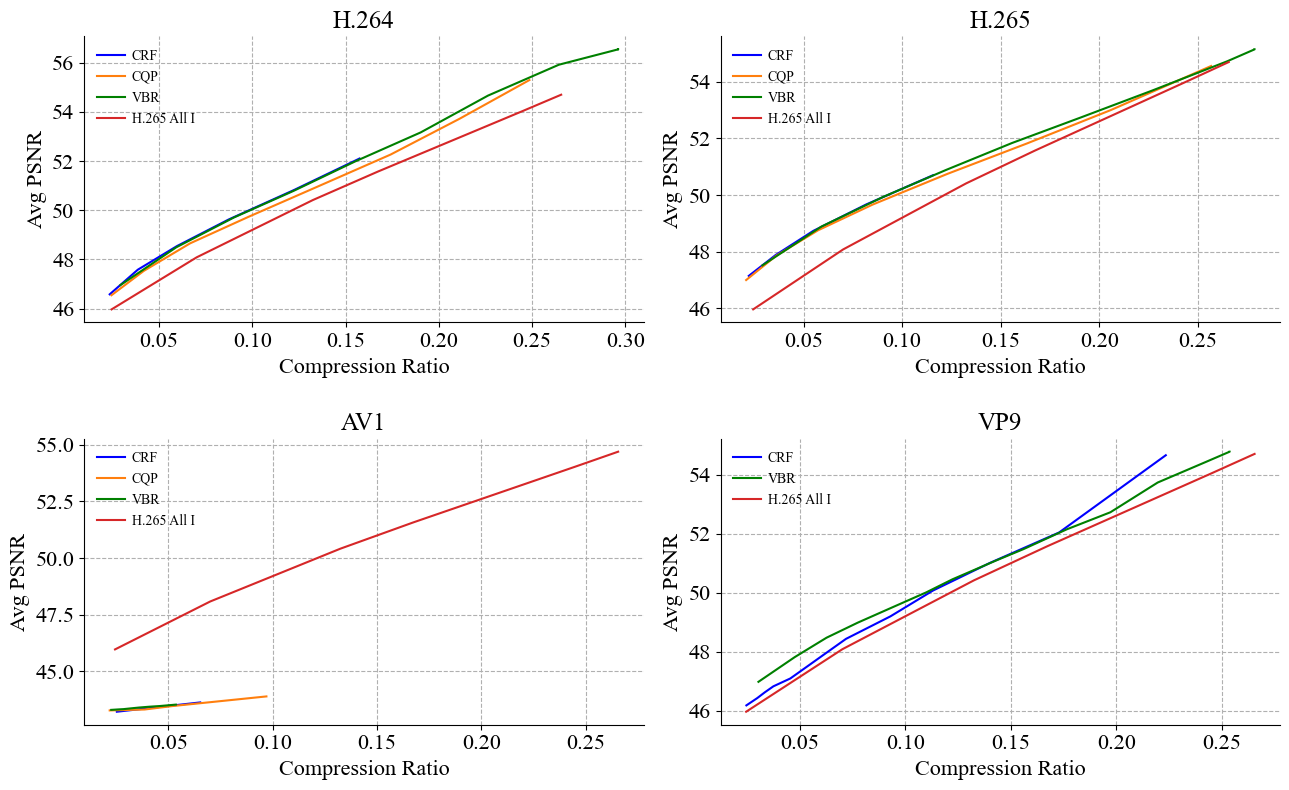

<Figure size 640x480 with 0 Axes>

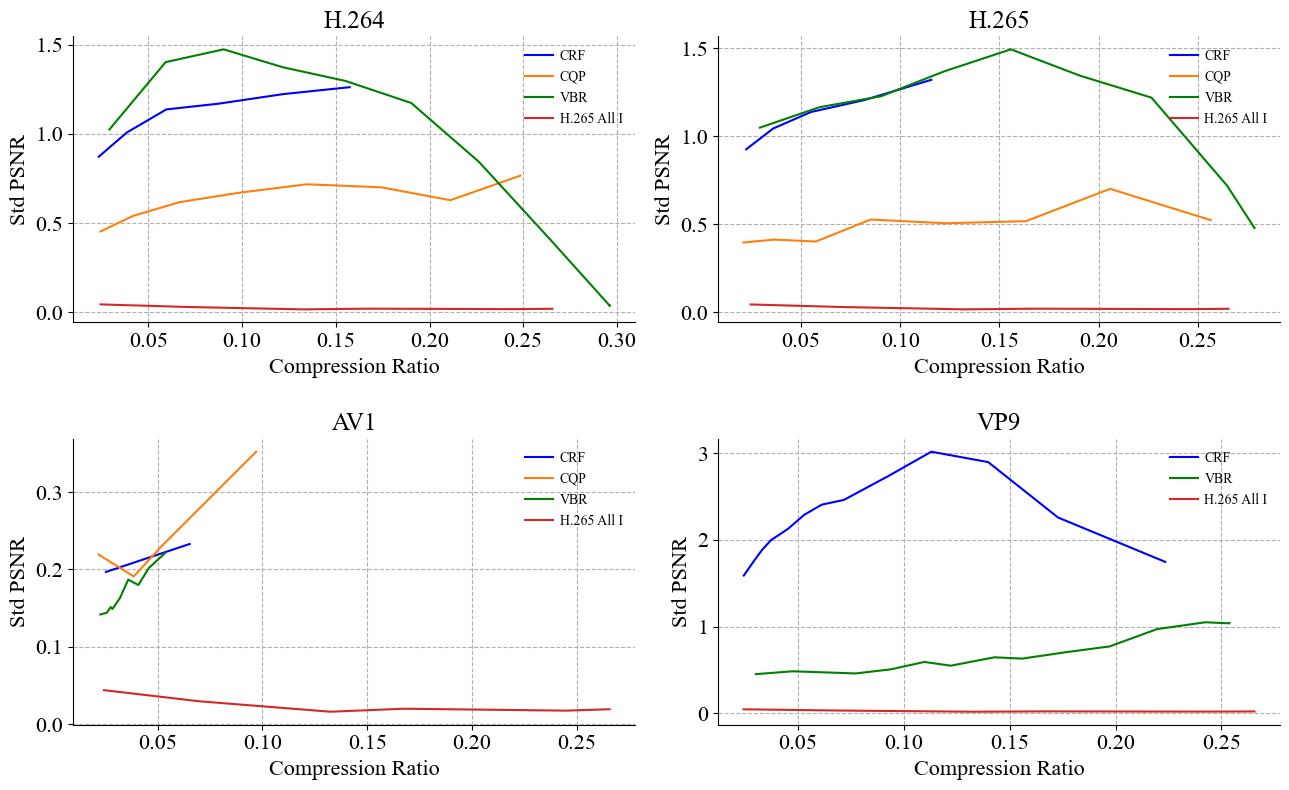

<Figure size 640x480 with 0 Axes>

In [6]:
lang.add_map(LangType.zh_cn,{
        'compression_ratio':'压缩率',
        'avg_psnr':'PSNR 平均值',
        'std_psnr':'PSNR 方差',
    }).add_map(LangType.en_us,{
        'compression_ratio':'Compression Ratio',
        'avg_psnr':'Avg PSNR',
        'std_psnr':'Std PSNR',
    })
def draw(data_1,data_2,data_3,data_4,row,cal,title,ylabel,colors=[None,None,None]):
    ax = axes[row,cal]
    # ax.invert_xaxis()
    if data_1 is not None:
        ax.plot(data_1[0],data_1[1],label='CRF',color=colors[0])
    if data_2 is not None:
        ax.plot(data_2[0],data_2[1],label='CQP',color=colors[1])
    if data_3 is not None:
        ax.plot(data_3[0],data_3[1],label='VBR',color=colors[2])
    if data_4 is not None:
        ax.plot(data_4[0],data_4[1],label='H.265 All I',color=colors[3])
    
    ax.set_title(title,fontsize=18)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xlabel(t('compression_ratio'),fontsize=16)
    ax.set_ylabel(ylabel,fontsize=16)
    ax.grid(True, linestyle='--')
    legend = ax.legend(handlelength=2, handletextpad=0.5,framealpha=0, edgecolor='#e6e6e6')#,loc='lower right'
    frame = legend.get_frame()
    frame.set_facecolor('white')
    return ax
fig, axes = plt.subplots(2, 2, figsize=(13, 8))
draw((x_h264_crf_mean,y_h264_crf_mean),(x_h264_qp_mean,y_h264_qp_mean),(x_h264_b_mean,y_h264_b_mean),(x_h265_alli_mean,y_h265_alli_mean),0,0,'H.264',t('avg_psnr'),['blue','#FF7F0E','green','#D62728'])
draw((x_h265_crf_mean,y_h265_crf_mean),(x_h265_qp_mean,y_h265_qp_mean),(x_h265_b_mean,y_h265_b_mean),(x_h265_alli_mean,y_h265_alli_mean),0,1,'H.265',t('avg_psnr'),['blue','#FF7F0E','green','#D62728'])
draw((x_av1_crf_mean,y_av1_crf_mean),(x_av1_qp_mean,y_av1_qp_mean),(x_av1_b_mean,y_av1_b_mean),(x_h265_alli_mean,y_h265_alli_mean),1,0,'AV1',t('avg_psnr'),['blue','#FF7F0E','green','#D62728'])
draw((x_vp9_crf_mean,y_vp9_crf_mean),None,(x_vp9_b_mean,y_vp9_b_mean),(x_h265_alli_mean,y_h265_alli_mean),1,1,'VP9',t('avg_psnr'),['blue',None,'green','#D62728'])
plt.tight_layout(h_pad=2.5)
plt.savefig(f"{outdir}/{dataset_name}_psnr_avg_{motion}.pdf",transparent=True,bbox_inches='tight')
plt.savefig(f"{outdir}/{dataset_name}_psnr_avg_{motion}.svg",transparent=True,bbox_inches='tight')
plt.savefig(f"{outdir}/{dataset_name}_psnr_avg_{motion}.png",transparent=True,bbox_inches='tight')
plt.show()
plt.clf()

fig, axes = plt.subplots(2, 2, figsize=(13, 8))
draw((x_h264_crf_std,y_h264_crf_std),(x_h264_qp_std,y_h264_qp_std),(x_h264_b_std,y_h264_b_std),(x_h265_alli_std,y_h265_alli_std),0,0,'H.264',t('std_psnr'),['blue','#FF7F0E','green','#D62728'])
draw((x_h265_crf_std,y_h265_crf_std),(x_h265_qp_std,y_h265_qp_std),(x_h265_b_std,y_h265_b_std),(x_h265_alli_std,y_h265_alli_std),0,1,'H.265',t('std_psnr'),['blue','#FF7F0E','green','#D62728'])
draw((x_av1_crf_std,y_av1_crf_std),(x_av1_qp_std,y_av1_qp_std),(x_av1_b_std,y_av1_b_std),(x_h265_alli_std,y_h265_alli_std),1,0,'AV1',t('std_psnr'),['blue','#FF7F0E','green','#D62728'])
draw((x_vp9_crf_std,y_vp9_crf_std),None,(x_vp9_b_std,y_vp9_b_std),(x_h265_alli_std,y_h265_alli_std),1,1,'VP9',t('std_psnr'),['blue',None,'green','#D62728'])
plt.tight_layout(h_pad=2.5)
plt.savefig(f"{outdir}/{dataset_name}_psnr_std_{motion}.pdf",transparent=True,bbox_inches='tight')
plt.savefig(f"{outdir}/{dataset_name}_psnr_std_{motion}.svg",transparent=True,bbox_inches='tight')
plt.savefig(f"{outdir}/{dataset_name}_psnr_std_{motion}.png",transparent=True,bbox_inches='tight')
plt.show()
plt.clf()

In [2]:
# pearson
from common.filter import lowpass_filter
from scipy.interpolate import UnivariateSpline


lang.add_map(LangType.zh_cn,{
        'compression_ratio':'压缩率',
        'pearson':'Pearson',
    }).add_map(LangType.en_us,{
        'compression_ratio':'Compression Ratio',
        'pearson':'Pearson',
    })

def get_x_y_p(codec,mode,method,motion):
    compression_strengths = range(1,36,1)
    if codec == 'mjpeg':
        compression_strengths = range(2,32)
    if codec == 'prores_ks':
        compression_strengths = range(0,5)
    if codec == 'libx264_all_i' or codec == 'libx265_all_i':
        compression_strengths = [1,4,8,10,14,20,24,30]
    x = list()
    y = list()
    z = list()
    for compression_strength in compression_strengths:
        df_pearson_and_snr = pd.read_excel(f'out/{dataset_name}/compression_ratios_{motion}.xlsx', sheet_name=f'{codec}_{mode}_{compression_strength}')
        x.append(df_pearson_and_snr.iloc[0,:].to_numpy().mean())
        df_psnr = pd.read_excel(f'out/{dataset_name}/{method}_pearson_and_snr_{motion}.xlsx', sheet_name=f'{codec}_{mode}_{compression_strength}')
        y.append(df_psnr.iloc[:,0].to_numpy().mean())
        z.append(df_psnr.iloc[:,1].to_numpy().mean())
    zipped = sorted(zip(x, y, z))
    # zipped = filter(lambda i:i[0]>=0.02 and i[0]<=0.2,zipped)
    x,y,z = zip(*zipped)
    if codec == 'prores_ks':
        # y = UnivariateSpline(x, y,k=3,s=1)(x)
        pass
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    return x,y,z

# static data
x_h264_crf_static,y_h264_crf_static,z_h264_crf_static = get_x_y_p('libx264','b','PhysNet','static')

x_h265_crf_static,y_h265_crf_static,z_h265_crf_static = get_x_y_p('libx265','qp','PhysNet','static')

x_av1_qp_static,y_av1_qp_static,z_av1_qp_static = get_x_y_p('av1','b','PhysNet','static')

x_vp9_crf_static,y_vp9_crf_static,z_vp9_crf_static = get_x_y_p('vp9','b','PhysNet','static')

x_prores_ks_q_static,y_prores_ks_q_static,z_prores_ks_q_static = get_x_y_p('prores_ks','q','PhysNet','static')

x_libx265_all_i_q_static,y_libx265_all_i_q_static,z_libx265_all_i_q_static = get_x_y_p('libx265_all_i','qp','PhysNet','static')
# wark data
x_h264_crf_wark,y_h264_crf_wark,z_h264_crf_wark = get_x_y_p('libx264','crf','PhysNet','wark')

x_h265_crf_wark,y_h265_crf_wark,z_h265_crf_wark = get_x_y_p('libx265','crf','PhysNet','wark')

x_av1_qp_wark,y_av1_qp_wark,z_av1_qp_wark = get_x_y_p('av1','crf','PhysNet','wark')

x_vp9_crf_wark,y_vp9_crf_wark,z_vp9_crf_wark = get_x_y_p('vp9','crf','PhysNet','wark')

x_prores_ks_q_wark,y_prores_ks_q_wark,z_prores_ks_q_wark = get_x_y_p('prores_ks','q','PhysNet','wark')

x_libx265_all_i_q_wark,y_libx265_all_i_q_wark,z_libx265_all_i_q_wark = get_x_y_p('libx265_all_i','qp','PhysNet','wark')

In [4]:
print(dataset_name + " " + motion)
if motion == 'static':
    ins_data = [(x_h264_crf_static,y_h264_crf_static,z_h264_crf_static),(x_h265_crf_static,y_h265_crf_static,z_h265_crf_static),(x_av1_qp_static,y_av1_qp_static,z_av1_qp_static),(x_vp9_crf_static,y_vp9_crf_static,z_vp9_crf_static),(x_libx265_all_i_q_static,y_libx265_all_i_q_static,z_libx265_all_i_q_static)]
else:
    ins_data = [(x_h264_crf_wark,y_h264_crf_wark,z_h264_crf_wark),(x_h265_crf_wark,y_h265_crf_wark,z_h265_crf_wark),(x_av1_qp_wark,y_av1_qp_wark,z_av1_qp_wark),(x_vp9_crf_wark,y_vp9_crf_wark,z_vp9_crf_wark),(x_libx265_all_i_q_wark,y_libx265_all_i_q_wark,z_libx265_all_i_q_wark)]

out_arr = None
for x_xp,y,z in ins_data:
    x_xp_min = x_xp.min()
    x_xp_max = x_xp.max()
    x = np.arange(0.02,0.25,0.005)
    x = np.around(x,decimals=3)
    x_temp = x.copy()
    
    y = np.interp(x,x_xp,y)
    z = np.interp(x,x_xp,z)

    y = np.around(y,decimals=4)
    z = np.around(z,decimals=4)
    indexs = x >= x_xp_min
    x = x[indexs]
    y = y[indexs]
    z = z[indexs]
    indexs = x <= x_xp_max
    x = x[indexs]
    y = y[indexs]
    z = z[indexs]

    out = dict()
    for i in range(len(x)):
        out[x[i]] = (y[i],z[i])
    if out_arr is None:
        out_arr = x_temp.copy().reshape((-1,1))
    yy = list()
    zz = list()
    for i in range(len(x_temp)):
        temp = out.get(x_temp[i],(0,0))
        yy.append(temp[0])
        zz.append(temp[1])
    out_arr = np.hstack((out_arr,np.array(yy).reshape(-1,1)))

    out_arr = np.hstack((out_arr,np.array(zz).reshape(-1,1)))
for rows in out_arr:
    print_str = f'{rows[0]:.3f}'
    # f"{x_temp[i]:.3f} & {temp[0]:.4f} & {temp[1]:.4f}"
    for cell in rows[1:]:
        if cell == 0:
            print_str+= f" &   -   "
        else:
            print_str += f" & {cell:.4f}"
    print_str += r" \\"
    print(print_str)    


ZJXU wark
0.020 & 0.9171 & 0.3968 & 0.9169 & 0.3974 & 0.9169 & 0.3970 & 0.9167 & 0.3976 & 0.9165 & 0.3982 \\
0.025 & 0.9171 & 0.3966 & 0.9169 & 0.3973 & 0.9169 & 0.3972 & 0.9170 & 0.3968 & 0.9167 & 0.3976 \\
0.030 & 0.9172 & 0.3966 & 0.9168 & 0.3975 & 0.9172 & 0.3964 & 0.9169 & 0.3972 & 0.9168 & 0.3974 \\
0.035 & 0.9172 & 0.3965 & 0.9169 & 0.3973 & 0.9171 & 0.3966 & 0.9170 & 0.3969 & 0.9169 & 0.3972 \\
0.040 & 0.9171 & 0.3968 & 0.9170 & 0.3971 & 0.9171 & 0.3967 & 0.9171 & 0.3967 & 0.9170 & 0.3969 \\
0.045 & 0.9173 & 0.3963 & 0.9171 & 0.3967 &   -    &   -    & 0.9171 & 0.3966 & 0.9171 & 0.3968 \\
0.050 & 0.9170 & 0.3969 & 0.9171 & 0.3967 &   -    &   -    & 0.9172 & 0.3966 & 0.9171 & 0.3968 \\
0.055 & 0.9172 & 0.3965 & 0.9172 & 0.3964 &   -    &   -    & 0.9172 & 0.3965 & 0.9171 & 0.3968 \\
0.060 & 0.9172 & 0.3965 &   -    &   -    &   -    &   -    & 0.9171 & 0.3966 & 0.9171 & 0.3969 \\
0.065 & 0.9172 & 0.3965 &   -    &   -    &   -    &   -    & 0.9171 & 0.3966 & 0.9171 & 0.3968 \\


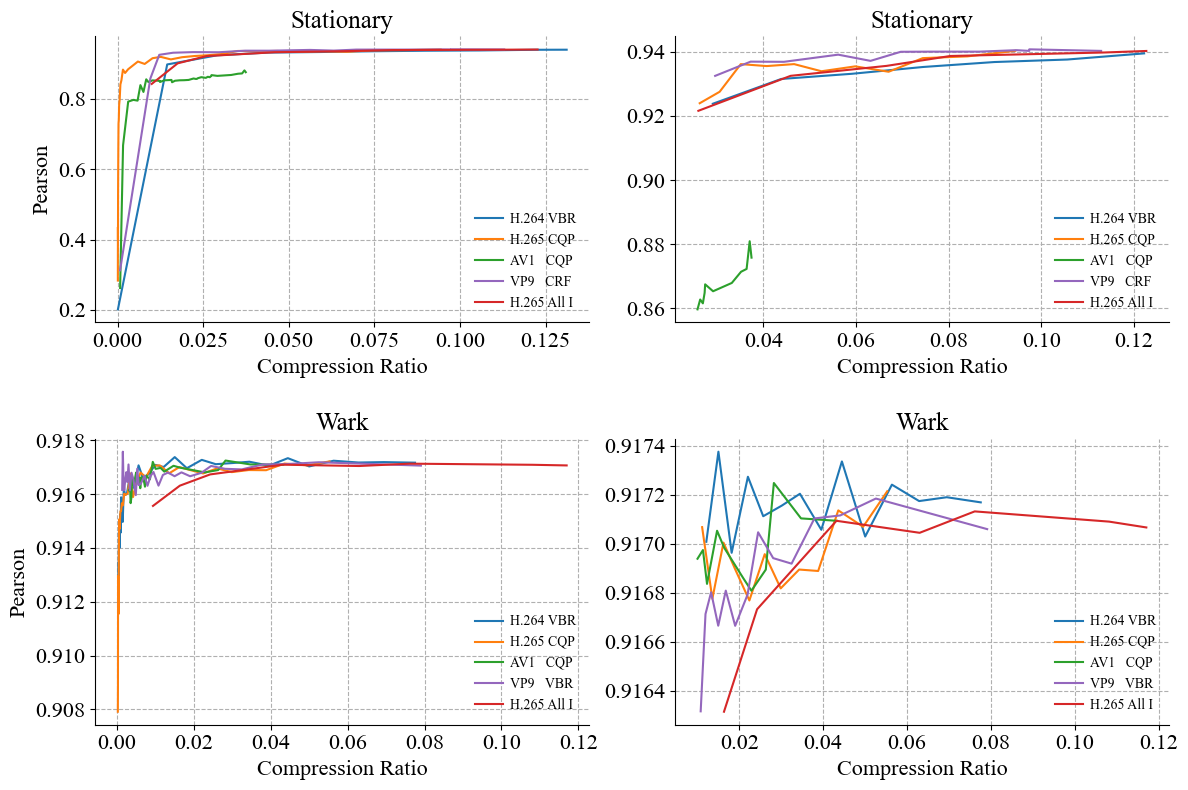

<Figure size 640x480 with 0 Axes>

In [4]:
def draw(data_1,data_2,data_3,data_4,data_5,row_cal,title):
    row,cal = row_cal
    ax = axes[row][cal]
    # ax.invert_xaxis()
    #1F77B4（柔和的蓝色）
    #FF7F0E（柔和的橙色）
    #2CA02C（柔和的绿色）
    #9467BD（柔和的紫色）
    #D62728（柔和的红色）
    infos = [(data_1,'H.264 VBR','#1F77B4'),(data_2,'H.265 CQP','#FF7F0E'),(data_3,'AV1   CQP','#2CA02C'),(data_4,'VP9   VBR' if  title == 'Wark' or title == 'T1' else 'VP9   CRF','#9467BD'),(data_5,'H.265 All I ','#D62728')]
    for info in infos:
        if info[0] != None:
            ax.plot(info[0][0],info[0][1],label=info[1],color=info[2])
    ax.set_title(title,fontsize=18)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xlabel(t('compression_ratio'),fontsize=16)
    if cal == 0:
        ax.set_ylabel(t('pearson'),fontsize=16)
    else:
        ax.set_ylabel(None)
    ax.grid(True, linestyle='--')
    legend = ax.legend(handlelength=2, handletextpad=0.5,framealpha=0, edgecolor='#e6e6e6',loc='lower right')
    frame = legend.get_frame()
    frame.set_facecolor('white')
    return ax
def compression_ratios_filter(x,y,min_r,max_r):
    zipped = zip(x,y)
    zipped = filter(lambda i:i[0]>=min_r and i[0]<=max_r,zipped)
    x_y_list = list(zipped)
    if len(x_y_list) == 0:
        return None
    x,y = zip(*x_y_list)
    x = np.array(x)
    y = np.array(y)
    return x,y
if dataset_name == "UBFC_Phys":
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    data = (x_h264_crf_static,y_h264_crf_static),(x_h265_crf_static,y_h265_crf_static),(x_av1_qp_static,y_av1_qp_static),(x_vp9_crf_static,y_vp9_crf_static),(x_libx265_all_i_q_static,y_libx265_all_i_q_static)
    draw(*data,(0,0),'T1')
    data = [compression_ratios_filter(x,y,0.1,0.25) for x,y in data]
    draw(*data,(0,1),'T1')

    data = (x_h264_crf_wark,y_h264_crf_wark),(x_h265_crf_wark,y_h265_crf_wark),(x_av1_qp_wark,y_av1_qp_wark),(x_vp9_crf_wark,y_vp9_crf_wark),(x_libx265_all_i_q_wark,y_libx265_all_i_q_wark)
    draw(*data,(1,0),'T3')
    data = [compression_ratios_filter(x,y,0.03,0.3) for x,y in data]
    draw(*data,(1,1),'T3')
if dataset_name == "ZJXU":
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    data = (x_h264_crf_static,y_h264_crf_static),(x_h265_crf_static,y_h265_crf_static),(x_av1_qp_static,y_av1_qp_static),(x_vp9_crf_static,y_vp9_crf_static),(x_libx265_all_i_q_static,y_libx265_all_i_q_static)
    draw(*data,(0,0),'Stationary')
    data = [compression_ratios_filter(x,y,0.025,0.125) for x,y in data]
    draw(*data,(0,1),'Stationary')

    data = (x_h264_crf_wark,y_h264_crf_wark),(x_h265_crf_wark,y_h265_crf_wark),(x_av1_qp_wark,y_av1_qp_wark),(x_vp9_crf_wark,y_vp9_crf_wark),(x_libx265_all_i_q_wark,y_libx265_all_i_q_wark)
    draw(*data,(1,0),'Wark')
    data = [compression_ratios_filter(x,y,0.01,0.3) for x,y in data]
    draw(*data,(1,1),'Wark')

plt.tight_layout(h_pad=2.5)
plt.savefig(f"{outdir}/{dataset_name}_pearson_compression_ratio.pdf",transparent=True)
plt.savefig(f"{outdir}/{dataset_name}_pearson_compression_ratio.svg",transparent=True)
plt.show()
plt.clf()